In [5]:
import requests
import pandas as pd
import numpy as np
import osmnx as ox
from datetime import datetime
import logging
from typing import Dict, List, Optional, Union
import time

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Define API keys and endpoints
OPENWEATHER_API_KEY = "9cdf050abe7b42592268c0bf78c0195a"
GBIF_API_BASE = "https://api.gbif.org/v1/occurrence/search"

# Add rate limiting parameters
REQUEST_DELAY = 1  # Delay between API requests in seconds

def fetch_climate_data(lat: float, lon: float) -> Optional[Dict]:
    """
    Fetch climate data using OpenWeatherMap API with improved precipitation handling.
    """
    try:
        url = f"https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={OPENWEATHER_API_KEY}&units=metric"
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        time.sleep(REQUEST_DELAY)
        
        # Improved precipitation handling
        precipitation = 0
        if "rain" in data:
            precipitation = data["rain"].get("1h", 0) or data["rain"].get("3h", 0)
        elif "snow" in data:
            precipitation = data["snow"].get("1h", 0) or data["snow"].get("3h", 0)
        
        return {
            "temperature": data["main"]["temp"],
            "precipitation": precipitation,
            "humidity": data["main"]["humidity"],
        }
    except Exception as e:
        logger.error(f"Error fetching climate data for {lat}, {lon}: {str(e)}")
        return None

def fetch_biodiversity_data(lat: float, lon: float) -> int:
    """
    Fetch biodiversity data using GBIF API with improved species counting.
    """
    try:
        params = {
            "decimalLatitude": f"{lat-0.5},{lat+0.5}",
            "decimalLongitude": f"{lon-0.5},{lon+0.5}",
            "limit": 300,  # Increased limit
            "hasCoordinate": True,
            "hasGeospatialIssue": False
        }
        response = requests.get(GBIF_API_BASE, params=params)
        response.raise_for_status()
        data = response.json()
        time.sleep(REQUEST_DELAY)
        
        # Count unique species
        species_set = set()
        for record in data.get("results", []):
            if record.get("species"):
                species_set.add(record["species"])
        
        return len(species_set)
    except Exception as e:
        logger.error(f"Error fetching biodiversity data for {lat}, {lon}: {str(e)}")
        return 0

def fetch_green_cover_data(lat: float, lon: float) -> float:
    """
    Fetch green cover data with improved NDVI calculation.
    """
    try:
        # Create a larger area for analysis
        dist = 1000  # increased from 500 to 1000 meters
        tags = {
            'landuse': ['forest', 'grass', 'park', 'meadow', 'recreation_ground'],
            'natural': ['wood', 'grassland', 'heath']
        }
        
        area = ox.geometries_from_point((lat, lon), tags=tags, dist=dist)
        
        if not area.empty:
            total_area = np.pi * (dist ** 2)  # Total circular area
            green_area = area.geometry.area.sum()
            ndvi_proxy = green_area / total_area
            return max(min(ndvi_proxy, 1), 0)
        return 0.0
    except Exception as e:
        logger.error(f"Error fetching green cover data for {lat}, {lon}: {str(e)}")
        return 0.0

def fetch_land_usage_data(lat: float, lon: float) -> float:
    """
    Fetch land usage data with improved urban density calculation.
    """
    try:
        dist = 1000  # Analysis radius in meters
        
        # Get both buildings and roads
        building_tags = {'building': True}
        buildings = ox.geometries_from_point((lat, lon), tags=building_tags, dist=dist)
        
        graph = ox.graph_from_point((lat, lon), dist=dist, network_type='all')
        
        total_area = np.pi * (dist ** 2)
        building_area = buildings.geometry.area.sum() if not buildings.empty else 0
        road_length = sum(d['length'] for u, v, d in graph.edges(data=True))
        
        # Combine building coverage and road density for urban usage metric
        urban_density = (building_area / total_area) + (road_length / (dist * 2 * np.pi))
        return max(min(urban_density, 1), 0)
    except Exception as e:
        logger.error(f"Error fetching land usage data for {lat}, {lon}: {str(e)}")
        return 0.0

def fetch_water_coverage_data(lat: float, lon: float) -> float:
    """
    Fetch water coverage data with improved calculation.
    """
    try:
        dist = 1000  # Analysis radius in meters
        water_tags = {
            'natural': ['water', 'wetland'],
            'water': True,
            'waterway': ['river', 'canal', 'stream']
        }
        
        water_features = ox.geometries_from_place((lat, lon), tags=water_tags, dist=dist)
        
        if not water_features.empty:
            total_area = np.pi * (dist ** 2)
            water_area = water_features.geometry.area.sum()
            water_coverage = water_area / total_area
            return max(min(water_coverage, 1), 0)
        return 0.0
    except Exception as e:
        logger.error(f"Error fetching water coverage data for {lat}, {lon}: {str(e)}")
        return 0.0

def generate_risk_score(
    ndvi: float,
    species_richness: int,
    urban_land_usage: float,
    water_coverage: float,
    land_use_type: str
) -> float:
    """
    Calculate a risk score based on environmental factors.
    
    Args:
        ndvi (float): Normalized Difference Vegetation Index
        species_richness (int): Number of species in area
        urban_land_usage (float): Urban density metric
        water_coverage (float): Water coverage ratio
        land_use_type (str): Type of land use
        
    Returns:
        float: Risk score between 0 and 1
    """
    land_use_weight = {
        "green-based use": 0.1,
        "agricultural use": 0.2,
        "urban home-type use": 0.3,
        "commercial/industrial use": 0.4
    }

    try:
        risk_score = (
            (1 - ndvi) * 0.35 +
            (species_richness / 100) * 0.25 +
            (urban_land_usage / 100) * 0.25 +
            (1 - water_coverage) * 0.15
        )
        
        risk_score *= land_use_weight.get(land_use_type, 0.25)
        return min(max(risk_score, 0), 1)
    except Exception as e:
        logger.error(f"Error generating risk score: {str(e)}")
        return 0.5

def create_dataset(
    regions: List[Dict[str, float]],
    land_use_types: List[str]
) -> pd.DataFrame:
    """
    Create a labeled dataset across various regions with selected land use types.
    
    Args:
        regions (list): List of dictionaries containing lat/lon coordinates
        land_use_types (list): List of land use type strings
        
    Returns:
        pandas.DataFrame: Dataset containing environmental metrics and risk scores
    """
    data = []
    total_regions = len(regions)
    
    for idx, region in enumerate(regions, 1):
        try:
            lat, lon = region["lat"], region["lon"]
            logger.info(f"Processing region {idx}/{total_regions}: {lat}, {lon}")
            
            climate_data = fetch_climate_data(lat, lon)
            biodiversity_data = fetch_biodiversity_data(lat, lon)
            green_cover = fetch_green_cover_data(lat, lon)
            land_usage = fetch_land_usage_data(lat, lon)
            water_coverage = fetch_water_coverage_data(lat, lon)
            
            if climate_data:
                for land_use_type in land_use_types:
                    risk_score = generate_risk_score(
                        green_cover,
                        biodiversity_data,
                        land_usage,
                        water_coverage,
                        land_use_type
                    )
                    
                    data.append({
                        "latitude": lat,
                        "longitude": lon,
                        "temperature": climate_data["temperature"],
                        "precipitation": climate_data["precipitation"],
                        "humidity": climate_data["humidity"],
                        "species_richness": biodiversity_data,
                        "ndvi": green_cover,
                        "urban_land_usage": land_usage,
                        "water_coverage": water_coverage,
                        "land_use_type": land_use_type,
                        "risk_score": risk_score,
                        # "timestamp": datetime.now().isoformat()
                    })
            
        except Exception as e:
            logger.error(f"Error processing region {lat}, {lon}: {str(e)}")
            continue
    
    return pd.DataFrame(data)

def main():
    """Main function to run the data collection and analysis."""
    # Define regions (example coordinates for various landscapes)
    regions = [
        {"lat": 10.7449, "lon": 92.5000},  # New York City, USA
        # {"lat": -33.8688, "lon": 151.2093},  # Sydney, Australia
        # {"lat": 51.5074, "lon": -0.1278},   # London, UK
        # {"lat": -1.286389, "lon": 36.817223},  # Nairobi, Kenya
        # {"lat": 28.6139, "lon": 77.2090}    # New Delhi, India
    ]

    # Define possible land use types
    land_use_types = [
        "green-based use",
        "agricultural use",
        "urban home-type use",
        "commercial/industrial use"
    ]

    try:
        # Create the dataset
        logger.info("Starting dataset creation...")
        dataset = create_dataset(regions, land_use_types)
        
        # Save to CSV
        # output_filename = f"urban_planning_risk_dataset_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        # dataset.to_csv(output_filename, index=False)
        # logger.info(f"Dataset successfully created and saved as '{output_filename}'")
        
        return dataset
    except Exception as e:
        logger.error(f"Error in main execution: {str(e)}")
        return None
dataset = main()

2025-01-19 01:46:55,424 - INFO - Starting dataset creation...
2025-01-19 01:46:55,425 - INFO - Processing region 1/1: 10.7449, 92.5
2025-01-19 01:47:10,180 - ERROR - Error fetching green cover data for 10.7449, 92.5: module 'osmnx' has no attribute 'geometries_from_point'
2025-01-19 01:47:10,182 - ERROR - Error fetching land usage data for 10.7449, 92.5: module 'osmnx' has no attribute 'geometries_from_point'
2025-01-19 01:47:10,183 - ERROR - Error fetching water coverage data for 10.7449, 92.5: module 'osmnx' has no attribute 'geometries_from_place'


In [6]:
l = (28.7975,76.1322)
l2 = (11,75)

In [7]:
def fetch_climate_data(lat: float, lon: float) -> Optional[Dict]:
    """
    Fetch climate data using OpenWeatherMap API with 5-day precipitation forecast.
    """
    try:
        # Get current weather
        current_url = f"https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={OPENWEATHER_API_KEY}&units=metric"
        current_response = requests.get(current_url)
        current_response.raise_for_status()
        current_data = current_response.json()
        
        # Get 5 day forecast with 3-hour steps
        forecast_url = f"https://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lon}&appid={OPENWEATHER_API_KEY}&units=metric"
        forecast_response = requests.get(forecast_url)
        forecast_response.raise_for_status()
        forecast_data = forecast_response.json()
        
        # Calculate average precipitation from forecast
        total_precipitation = 0
        count = 0
        
        for item in forecast_data.get('list', []):
            # Get precipitation (rain or snow)
            rain_amount = item.get('rain', {}).get('3h', 0)
            snow_amount = item.get('snow', {}).get('3h', 0)
            total_precipitation += rain_amount + snow_amount
            count += 1
        
        # Convert 3-hourly precipitation to daily average
        avg_daily_precipitation = (total_precipitation / count) * 8 if count > 0 else 0
        # Estimate monthly precipitation (multiply by 30 days)
        estimated_monthly_precipitation = avg_daily_precipitation * 30
        
        return {
            "temperature": current_data["main"]["temp"],
            "precipitation": estimated_monthly_precipitation,
            "humidity": current_data["main"]["humidity"],
        }
        
    except Exception as e:
        logger.error(f"Error fetching climate data for {lat}, {lon}: {str(e)}")
        return None
    finally:
        time.sleep(REQUEST_DELAY)
        

In [8]:
fetch_climate_data(*l)

{'temperature': 12.27, 'precipitation': 1.7999999999999998, 'humidity': 49}

In [9]:
def fetch_biodiversity_data(lat: float, lon: float) -> int:
    """
    Fetch biodiversity data using GBIF API with improved species counting.
    """
    try:
        params = {
            "decimalLatitude": f"{lat-0.5},{lat+0.5}",
            "decimalLongitude": f"{lon-0.5},{lon+0.5}",
            "limit": 300,  # Increased limit
            "hasCoordinate": True,
            "hasGeospatialIssue": False
        }
        response = requests.get(GBIF_API_BASE, params=params)
        response.raise_for_status()
        data = response.json()
        time.sleep(REQUEST_DELAY)
        
        # Count unique species
        species_set = set()
        for record in data.get("results", []):
            if record.get("species"):
                species_set.add(record["species"])
        
        return len(species_set)
    except Exception as e:
        logger.error(f"Error fetching biodiversity data for {lat}, {lon}: {str(e)}")
        return 0

In [10]:
fetch_biodiversity_data(l[0],l[1])

124

In [11]:
import ee
import requests
import numpy as np
from datetime import datetime, timedelta
import logging
from typing import Optional

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def fetch_green_cover_data(lat: float, lon: float) -> float:
    """
    Fetch green cover data using Copernicus Global Land Service API.
    Uses NDVI (Normalized Difference Vegetation Index) data.
    
    Args:
        lat (float): Latitude
        lon (float): Longitude
    
    Returns:
        float: NDVI value between 0 and 1
    """
    try:
        # Using Copernicus Global Land Service API
        base_url = "https://land.copernicus.vgt.vito.be/REST/TimeSeries/1.0/extract"
        
        # Current date and one month ago
        end_date = datetime.now()
        start_date = end_date - timedelta(days=30)
        
        params = {
            'lat': lat,
            'lon': lon,
            'startdate': start_date.strftime('%Y-%m-%d'),
            'enddate': end_date.strftime('%Y-%m-%d'),
            'collection': 'NDVI_V2',
            'format': 'json'
        }
        
        headers = {
            'User-Agent': 'Mozilla/5.0',
            'Accept': 'application/json'
        }
        
        response = requests.get(base_url, params=params, headers=headers)
        
        if response.status_code != 200:
            # Fallback to alternative API: OpenMeteo
            return _fetch_green_cover_fallback(lat, lon)
            
        data = response.json()
        ndvi_values = [item['NDVI'] for item in data['results'] if 'NDVI' in item]
        
        if ndvi_values:
            # NDVI values are typically between -1 and 1
            # Normalize to 0-1 range
            avg_ndvi = np.mean(ndvi_values)
            normalized_ndvi = (avg_ndvi + 1) / 2
            return max(min(normalized_ndvi, 1), 0)
            
        return _fetch_green_cover_fallback(lat, lon)
        
    except Exception as e:
        logger.error(f"Error in primary green cover fetch: {str(e)}")
        return _fetch_green_cover_fallback(lat, lon)

def _fetch_green_cover_fallback(lat: float, lon: float) -> float:
    """
    Fallback method using OpenMeteo API for vegetation data.
    """
    try:
        # OpenMeteo API for soil and vegetation data
        url = (f"https://api.open-meteo.com/v1/forecast?"
               f"latitude={lat}&longitude={lon}"
               f"&hourly=soil_moisture_0_1cm,soil_moisture_1_3cm"
               f"&daily=et0_fao_evapotranspiration")
        
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        
        # Calculate green cover proxy using soil moisture and evapotranspiration
        soil_moisture = np.mean(data['hourly']['soil_moisture_0_1cm'][:24])  # First 24 hours
        evapotranspiration = data['daily']['et0_fao_evapotranspiration'][0]  # First day
        
        # Combine metrics to estimate vegetation cover
        # Normalize values based on typical ranges
        soil_moisture_norm = min(soil_moisture / 50, 1)  # Typical range 0-50
        evapotrans_norm = min(evapotranspiration / 10, 1)  # Typical range 0-10
        
        # Weight the factors
        green_cover = (soil_moisture_norm * 0.6 + evapotrans_norm * 0.4)
        
        return max(min(green_cover, 1), 0)
        
    except Exception as e:
        logger.error(f"Error in fallback green cover fetch: {str(e)}")
        return _fetch_green_cover_last_resort(lat, lon)

def _fetch_green_cover_last_resort(lat: float, lon: float) -> float:
    """
    Last resort method using NASA POWER API for vegetation-related data.
    """
    try:
        # NASA POWER API
        base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"
        
        params = {
            'parameters': 'T2M,PRECTOT,RH2M',  # Temperature, precipitation, humidity
            'community': 'AG',
            'longitude': lon,
            'latitude': lat,
            'start': datetime.now().strftime('%Y%m%d'),
            'end': datetime.now().strftime('%Y%m%d'),
            'format': 'JSON'
        }
        
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        
        # Extract relevant parameters
        temp = float(data['properties']['parameter']['T2M'][datetime.now().strftime('%Y%m%d')])
        precip = float(data['properties']['parameter']['PRECTOT'][datetime.now().strftime('%Y%m%d')])
        humidity = float(data['properties']['parameter']['RH2M'][datetime.now().strftime('%Y%m%d')])
        
        # Create a simple vegetation index based on environmental conditions
        # This is a rough approximation based on typical conditions favorable for vegetation
        temp_factor = max(0, min(1 - abs(temp - 20) / 30, 1))  # Optimal temp around 20°C
        precip_factor = min(precip / 10, 1)  # Normalize precipitation (0-10mm)
        humidity_factor = humidity / 100  # Humidity is already 0-100
        
        # Combine factors with weights
        green_cover = (temp_factor * 0.3 + precip_factor * 0.4 + humidity_factor * 0.3)
        
        return max(min(green_cover, 1), 0)
        
    except Exception as e:
        logger.error(f"Error in last resort green cover fetch: {str(e)}")
        # Return a reasonable default based on global averages
        return 0.3  # Global average vegetation cover is roughly 30%

def test_green_cover():
    """
    Test function to demonstrate usage and verify functionality.
    """
    # Test coordinates (example: New Delhi, India)
    test_locations = [
        # (28.7041, 77.1025, "New Delhi"),
        # (40.7128, -74.0060, "New York"),
        # (51.5074, -0.1278, "London"),
        # (11,75,"Andaman"),
        # (15,71,"amazon"),
        (0,75,'antartica')
    ]
    
    for lat, lon, name in test_locations:
        try:
            green_cover = fetch_green_cover_data(lat, lon)
            print(f"\nGreen cover index for {name} ({lat}, {lon}): {green_cover:.4f}")
        except Exception as e:
            print(f"Error testing {name}: {str(e)}")

if __name__ == "__main__":
    test_green_cover()

2025-01-19 01:47:24,024 - ERROR - Error in primary green cover fetch: Expecting value: line 1 column 1 (char 0)



Green cover index for antartica (0, 75): 0.1608


In [12]:
fetch_green_cover_data(*l)

2025-01-19 01:47:27,352 - ERROR - Error in primary green cover fetch: Expecting value: line 1 column 1 (char 0)


0.067261

In [13]:
def fetch_land_usage_data(lat: float, lon: float) -> float:
    """
    Fetch land usage data with improved urban density calculation.
    """
    try:
        dist = 1000  # Analysis radius in meters
        
        # Get both buildings and roads
        building_tags = {'building': True}
        buildings = ox.geometries_from_point((lat, lon), tags=building_tags, dist=dist)
        
        graph = ox.graph_from_point((lat, lon), dist=dist, network_type='all')
        
        total_area = np.pi * (dist ** 2)
        building_area = buildings.geometry.area.sum() if not buildings.empty else 0
        road_length = sum(d['length'] for u, v, d in graph.edges(data=True))
        
        # Combine building coverage and road density for urban usage metric
        urban_density = (building_area / total_area) + (road_length / (dist * 2 * np.pi))
        return max(min(urban_density, 1), 0)
    except Exception as e:
        logger.error(f"Error fetching land usage data for {lat}, {lon}: {str(e)}")
        return 0.0

In [14]:
fetch_land_usage_data(*l2)

2025-01-19 01:47:28,701 - ERROR - Error fetching land usage data for 11, 75: module 'osmnx' has no attribute 'geometries_from_point'


0.0

In [15]:
import requests
import numpy as np
import logging
from typing import Dict, Tuple
from shapely.geometry import Polygon, MultiPolygon, LineString
from shapely.ops import unary_union
import json

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def _get_overpass_data(query: str) -> Dict:
    """
    Helper function to fetch data from Overpass API.
    """
    overpass_url = "https://overpass-api.de/api/interpreter"
    try:
        response = requests.post(overpass_url, data={'data': query})
        response.raise_for_status()
        return response.json()
    except Exception as e:
        logger.error(f"Overpass API error: {str(e)}")
        return {'elements': []}

def fetch_land_usage_data(lat: float, lon: float) -> float:
    """
    Fetch land usage data using Overpass API.
    Returns urban density index between 0 and 1.
    """
    try:
        # Calculate bounding box (1km radius)
        radius = 1000  # meters
        deg_radius = radius / 111320  # Convert meters to degrees (approximate)
        
        # Overpass query for buildings and roads
        query = f"""
        [out:json][timeout:25];
        (
          way["building"](around:{radius},{lat},{lon});
          way["highway"](around:{radius},{lat},{lon});
        );
        out body geom;
        """
        
        data = _get_overpass_data(query)
        
        if not data['elements']:
            # Fallback to secondary API
            return _fetch_land_usage_fallback(lat, lon)
        
        # Calculate areas and lengths
        total_area = np.pi * (radius ** 2)  # Total circular area in square meters
        building_area = 0
        road_length = 0
        
        for element in data['elements']:
            if 'geometry' in element:
                coords = [(p['lon'], p['lat']) for p in element['geometry']]
                if element.get('tags', {}).get('building'):
                    # Calculate building area
                    if len(coords) >= 3:
                        try:
                            polygon = Polygon(coords)
                            building_area += polygon.area * 111320 * 111320  # Convert to square meters
                        except:
                            continue
                elif element.get('tags', {}).get('highway'):
                    # Calculate road length
                    if len(coords) >= 2:
                        try:
                            line = LineString(coords)
                            road_length += line.length * 111320  # Convert to meters
                        except:
                            continue
        
        # Calculate urban density
        building_density = min(building_area / total_area, 0.7)  # Cap at 70%
        road_density = min(road_length / (radius * 2 * np.pi), 0.3)  # Cap at 30%
        
        urban_density = building_density + road_density
        return min(max(urban_density, 0), 1)
    
    except Exception as e:
        logger.error(f"Error in primary land usage calculation: {str(e)}")
        return _fetch_land_usage_fallback(lat, lon)

def _fetch_land_usage_fallback(lat: float, lon: float) -> float:
    """
    Fallback method using OpenStreetMap Nominatim API for land use data.
    """
    try:
        # Use Nominatim API to get area details
        nominatim_url = f"https://nominatim.openstreetmap.org/reverse?lat={lat}&lon={lon}&format=json&zoom=14"
        headers = {'User-Agent': 'Urban Density Calculator 1.0'}
        
        response = requests.get(nominatim_url, headers=headers)
        response.raise_for_status()
        data = response.json()
        
        # Analyze address components and category
        address = data.get('address', {})
        category = data.get('category', '')
        
        # Calculate urban density based on location type
        if any(k in address for k in ['city', 'town', 'suburb']):
            return 0.8  # Urban area
        elif 'village' in address:
            return 0.4  # Rural settlement
        elif any(k in address for k in ['industrial', 'commercial']):
            return 0.9  # Industrial/commercial area
        elif any(k in address for k in ['forest', 'park', 'nature_reserve']):
            return 0.1  # Natural area
        else:
            return 0.5  # Default semi-urban
            
    except Exception as e:
        logger.error(f"Error in fallback land usage calculation: {str(e)}")
        return 0.5  # Default value

def fetch_water_coverage_data(lat: float, lon: float) -> float:
    """
    Fetch water coverage data using Overpass API.
    Returns water coverage ratio between 0 and 1.
    """
    try:
        # Calculate bounding box (1km radius)
        radius = 1000  # meters
        
        # Overpass query for water features
        query = f"""
        [out:json][timeout:25];
        (
          way["natural"="water"](around:{radius},{lat},{lon});
          way["waterway"](around:{radius},{lat},{lon});
          way["water"](around:{radius},{lat},{lon});
          way["natural"="wetland"](around:{radius},{lat},{lon});
        );
        out body geom;
        """
        
        data = _get_overpass_data(query)
        
        if not data['elements']:
            # Fallback to secondary API
            return _fetch_water_coverage_fallback(lat, lon)
        
        # Calculate areas
        total_area = np.pi * (radius ** 2)  # Total circular area in square meters
        water_area = 0
        
        for element in data['elements']:
            if 'geometry' in element:
                coords = [(p['lon'], p['lat']) for p in element['geometry']]
                if len(coords) >= 3:
                    try:
                        polygon = Polygon(coords)
                        water_area += polygon.area * 111320 * 111320  # Convert to square meters
                    except:
                        continue
        
        water_coverage = water_area / total_area
        return min(max(water_coverage, 0), 1)
    
    except Exception as e:
        logger.error(f"Error in primary water coverage calculation: {str(e)}")
        return _fetch_water_coverage_fallback(lat, lon)

def _fetch_water_coverage_fallback(lat: float, lon: float) -> float:
    """
    Fallback method using OpenMeteo API for water proximity data.
    """
    try:
        # Use OpenMeteo API for water-related data
        url = f"https://marine-api.open-meteo.com/v1/marine?latitude={lat}&longitude={lon}&daily=wave_height"
        
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        
        if 'daily' in data and 'wave_height' in data['daily']:
            # If wave height data is available, location is near water
            return min(max(np.mean(data['daily']['wave_height']) / 2, 0), 1)
            
        # If no marine data, check for inland water bodies using Nominatim
        nominatim_url = f"https://nominatim.openstreetmap.org/reverse?lat={lat}&lon={lon}&format=json&zoom=14"
        headers = {'User-Agent': 'Water Coverage Calculator 1.0'}
        
        response = requests.get(nominatim_url, headers=headers)
        response.raise_for_status()
        data = response.json()
        
        # Check location type
        if any(water_type in str(data).lower() for water_type in ['lake', 'river', 'sea', 'ocean', 'bay', 'wetland']):
            return 0.7  # Significant water presence
        return 0.1  # Minimal water presence
            
    except Exception as e:
        logger.error(f"Error in fallback water coverage calculation: {str(e)}")
        return 0.1  # Default low water coverage

def test_coverage_calculations():
    """
    Test function to demonstrate usage of both functions.
    """
    test_locations = [
        (40.7128, -74.0060, "New York"),  # New York
        (51.5074, -0.1278, "London"),    # London
        (22.3964, 114.1095, "Hong Kong"), # Hong Kong
        (23.7957,86.4304, "dhanbad")    # Sydney
    ]
    
    for lat, lon, name in test_locations:
        try:
            land_usage = fetch_land_usage_data(lat, lon)
            water_coverage = fetch_water_coverage_data(lat, lon)
            
            print(f"\nResults for {name} ({lat}, {lon}):")
            print(f"Urban Density Index: {land_usage:.4f}")
            print(f"Water Coverage Index: {water_coverage:.4f}")
            
        except Exception as e:
            print(f"Error testing {name}: {str(e)}")

if __name__ == "__main__":
    test_coverage_calculations()


Results for New York (40.7128, -74.006):
Urban Density Index: 0.8148
Water Coverage Index: 0.0054


KeyboardInterrupt: 

In [26]:
import pandas as pd
from datetime import datetime
import logging
from typing import Dict, List

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Define development scenarios
DEVELOPMENT_SCENARIOS = {
    "Natural Reserve": "green-based use",
    "Agricultural Zone": "agricultural use",
    "Residential Area": "urban home-type use",
    "Industrial Zone": "commercial/industrial use"
}

# Representative locations for each continent
CONTINENTAL_LOCATIONS = [
    {
        "continent": "North America",
        "location": "Yellowstone, USA",
        "lat": 44.4280,
        "lon": -110.5885
    },
    {
        "continent": "South America",
        "location": "Amazon Rainforest, Brazil",
        "lat": -3.4653,
        "lon": -62.2159
    },
    {
        "continent": "Europe",
        "location": "Black Forest, Germany",
        "lat": 47.8044,
        "lon": 8.1735
    },
    {
        "continent": "Africa",
        "location": "Serengeti, Tanzania",
        "lat": -2.1540,
        "lon": 34.6857
    },
    {
        "continent": "Asia",
        "location": "Western Ghats, India",
        "lat": 10.7449,
        "lon": 76.7827
    },
    {
        "continent": "Oceania",
        "location": "Great Barrier Reef Coast, Australia",
        "lat": -16.2864,
        "lon": 145.6845
    },
    {
        "continent": "Antarctica",
        "location": "Antarctic Peninsula",
        "lat": -64.2314,
        "lon": -56.7242
    }
]

def calculate_location_risk(lat: float, lon: float, location_name: str, continent: str) -> List[Dict]:
    """Calculate biodiversity risk scores for all development scenarios at a location."""
    results = []
    
    try:
        # Fetch environmental data
        climate_data = fetch_climate_data(lat, lon)
        green_cover = fetch_green_cover_data(lat, lon)
        species_count = fetch_biodiversity_data(lat, lon)
        urban_usage = fetch_land_usage_data(lat, lon)
        water_coverage = fetch_water_coverage_data(lat, lon)
        
        # Calculate risk scores for each development scenario
        for scenario_name, land_use_type in DEVELOPMENT_SCENARIOS.items():
            risk_score = generate_risk_score(
                ndvi=green_cover,
                species_richness=species_count,
                urban_land_usage=urban_usage,
                water_coverage=water_coverage,
                land_use_type=land_use_type
            )
            
            results.append({
                "continent": continent,
                "location": location_name,
                "latitude": lat,
                "longitude": lon,
                "development_scenario": scenario_name,
                "risk_score": risk_score,
                "environmental_factors": {
                    "green_cover": green_cover,
                    "species_count": species_count,
                    "urban_density": urban_usage,
                    "water_coverage": water_coverage,
                    "temperature": climate_data.get("temperature") if climate_data else None,
                    "precipitation": climate_data.get("precipitation") if climate_data else None
                }
            })
            
        return results
    except Exception as e:
        logger.error(f"Error calculating risk for {location_name}: {str(e)}")
        return []

def main():
    """Calculate and display biodiversity risk scores for all locations."""
    all_results = []
    
    for location in CONTINENTAL_LOCATIONS:
        logger.info(f"Analyzing {location['location']} ({location['continent']})")
        results = calculate_location_risk(
            location["lat"],
            location["lon"],
            location["location"],
            location["continent"]
        )
        all_results.extend(results)
    
    # Create DataFrame for analysis
    df = pd.DataFrame(all_results)
    
    # Display results
    print("\nBiodiversity Risk Analysis by Continental Location and Development Scenario")
    print(f"Analysis Date (UTC): {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')}")
    print("\nRisk Score Scale: 0 (Lowest Risk) to 1 (Highest Risk)")
    print("-" * 80)
    
    for continent in df["continent"].unique():
        print(f"\n{continent} Analysis:")
        continent_data = df[df["continent"] == continent]
        
        for _, row in continent_data.iterrows():
            env_factors = row["environmental_factors"]
            print(f"\nLocation: {row['location']} ({row['latitude']:.4f}, {row['longitude']:.4f})")
            print(f"Development Scenario: {row['development_scenario']}")
            print(f"Risk Score: {row['risk_score']:.4f}")
            print(f"Environmental Factors:")
            print(f"  - Green Cover Index: {env_factors['green_cover']:.4f}")
            print(f"  - Species Count: {env_factors['species_count']}")
            print(f"  - Urban Density: {env_factors['urban_density']:.4f}")
            print(f"  - Water Coverage: {env_factors['water_coverage']:.4f}")
            if env_factors['temperature'] is not None:
                print(f"  - Temperature: {env_factors['temperature']:.1f}°C")
            if env_factors['precipitation'] is not None:
                print(f"  - Precipitation: {env_factors['precipitation']:.1f}mm")
        print("-" * 80)
    
    # Summary statistics
    print("\nSummary Statistics:")
    print(f"Average Risk Score by Development Scenario:")
    print(df.groupby("development_scenario")["risk_score"].mean().round(4))
    print("\nHighest Risk Locations:")
    print(df.nlargest(5, "risk_score")[["continent", "location", "development_scenario", "risk_score"]])

if __name__ == "__main__":
    main()

2025-01-19 01:47:48,849 - INFO - Analyzing Yellowstone, USA (North America)


KeyboardInterrupt: 

In [169]:
lst = [
    {
        "Latitude": -3.4653,
        "Longitude": 114.6984,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.8
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "medium",
        "Risk Score": 0.5
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "medium",
        "Risk Score": 0.5
    },
    {
        "Latitude": -23.5505,
        "Longitude": -46.6333,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": 19.4326,
        "Longitude": -99.1332,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "medium",
        "Risk Score": 0.5
    },
    {
        "Latitude": 28.6139,
        "Longitude": 77.2090,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -1.2921,
        "Longitude": 36.8219,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 60.1699,
        "Longitude": 24.9384,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 35.6762,
        "Longitude": 139.6503,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "medium",
        "Risk Score": 0.5
    },
    {
        "Latitude": 37.7749,
        "Longitude": -122.4194,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "medium",
        "Risk Score": 0.5
    },
    {
        "Latitude": 1.3521,
        "Longitude": 103.8198,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -26.2041,
        "Longitude": 28.0473,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "medium",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": 55.9533,
        "Longitude": -3.1883,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 59.3293,
        "Longitude": 18.0686,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 31.2304,
        "Longitude": 121.4737,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -19.9167,
        "Longitude": -43.9345,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 45.4642,
        "Longitude": 9.19,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "medium",
        "Risk Score": 0.5
    },
    {
        "Latitude": 41.9028,
        "Longitude": 12.4964,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6762,
        "Longitude": 139.6503,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "medium",
        "Risk Score": 0.5
    },
    {
        "Latitude": 28.7041,
        "Longitude": 77.1025,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 39.9042,
        "Longitude": 116.4074,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "medium",
        "Risk Score": 0.5
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": -25.2744,
        "Longitude": 133.7751,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 19.0760,
        "Longitude": 72.8777,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "medium",
        "Risk Score": 0.5
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": 1.3521,
        "Longitude": 103.8198,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "medium",
        "Risk Score": 0.5
    },
    {
        "Latitude": 35.6762,
        "Longitude": 139.6503,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 55.9533,
        "Longitude": -3.1883,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "medium",
        "Risk Score": 0.5
    },
    {
        "Latitude": 28.6139,
        "Longitude": 77.2090,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -1.2921,
        "Longitude": 36.8219,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 19.4326,
        "Longitude": -99.1332,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "medium",
        "Risk Score": 0.5
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 41.9028,
        "Longitude": 12.4964,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "medium",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6762,
        "Longitude": 139.6503,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "medium",
        "Risk Score": 0.5
    }
]
lst2 = [
    {
        "Latitude": -15.7942,
        "Longitude": -47.8822,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 10.8231,
        "Longitude": 106.6297,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 27.1751,
        "Longitude": 78.0421,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 51.1657,
        "Longitude": 10.4515,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -33.9249,
        "Longitude": 18.4241,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 19.0760,
        "Longitude": 72.8777,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 40.4168,
        "Longitude": -3.7038,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6762,
        "Longitude": 139.6503,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 1.3521,
        "Longitude": 103.8198,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -1.2864,
        "Longitude": 36.8172,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 19.4326,
        "Longitude": -99.1332,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 55.9533,
        "Longitude": -3.1883,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.6937,
        "Longitude": 135.5023,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 37.7749,
        "Longitude": -122.4194,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -25.2744,
        "Longitude": 133.7751,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6503,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 19.0760,
        "Longitude": 72.8777,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.6937,
        "Longitude": 135.5023,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 37.7749,
        "Longitude": -122.4194,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -25.2744,
        "Longitude": 133.7751,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6503,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 19.0760,
        "Longitude": 72.8777,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.6937,
        "Longitude": 135.5023,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 37.7749,
        "Longitude": -122.4194,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -25.2744,
        "Longitude": 133.7751,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6503,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 19.0760,
        "Longitude": 72.8777,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.6937,
        "Longitude": 135.5023,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 37.7749,
        "Longitude": -122.4194,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -25.2744,
        "Longitude": 133.7751,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6503,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 19.0760,
        "Longitude": 72.8777,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.6937,
        "Longitude": 135.5023,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 37.7749,
        "Longitude": -122.4194,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -25.2744,
        "Longitude": 133.7751,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6503,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 19.0760,
        "Longitude": 72.8777,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.6937,
        "Longitude": 135.5023,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 37.7749,
        "Longitude": -122.4194,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -25.2744,
        "Longitude": 133.7751,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6503,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 19.0760,
        "Longitude": 72.8777,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.6937,
        "Longitude": 135.5023,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 37.7749,
        "Longitude": -122.4194,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -25.2744,
        "Longitude": 133.7751,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6503,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 19.0760,
        "Longitude": 72.8777,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.6937,
        "Longitude": 135.5023,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 37.7749,
        "Longitude": -122.4194,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -25.2744,
        "Longitude": 133.7751,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6503,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 19.0760,
        "Longitude": 72.8777,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.6937,
        "Longitude": 135.5023,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 37.7749,
        "Longitude": -122.4194,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -25.2744,
        "Longitude": 133.7751,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6503,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 19.0760,
        "Longitude": 72.8777,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.6937,
        "Longitude": 135.5023,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 37.7749,
        "Longitude": -122.4194,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -25.2744,
        "Longitude": 133.7751,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6503,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 19.0760,
        "Longitude": 72.8777,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.6937,
        "Longitude": 135.5023,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 37.7749,
        "Longitude": -122.4194,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -25.2744,
        "Longitude": 133.7751,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6503,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 19.0760,
        "Longitude": 72.8777,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.6937,
        "Longitude": 135.5023,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 37.7749,
        "Longitude": -122.4194,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -25.2744,
        "Longitude": 133.7751,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6503,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 19.0760,
        "Longitude": 72.8777,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.6937,
        "Longitude": 135.5023,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 37.7749,
        "Longitude": -122.4194,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -25.2744,
        "Longitude": 133.7751,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6503,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 19.0760,
        "Longitude": 72.8777,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.6937,
        "Longitude": 135.5023,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 37.7749,
        "Longitude": -122.4194,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -25.2744,
        "Longitude": 133.7751,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6503,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 19.0760,
        "Longitude": 72.8777,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.6937,
        "Longitude": 135.5023,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 37.7749,
        "Longitude": -122.4194,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -25.2744,
        "Longitude": 133.7751,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6503,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 19.0760,
        "Longitude": 72.8777,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.6937,
        "Longitude": 135.5023,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 37.7749,
        "Longitude": -122.4194,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -25.2744,
        "Longitude": 133.7751,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6503,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 19.0760,
        "Longitude": 72.8777,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.6937,
        "Longitude": 135.5023,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 37.7749,
        "Longitude": -122.4194,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -25.2744,
        "Longitude": 133.7751,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6503,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 19.0760,
        "Longitude": 72.8777,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.6937,
        "Longitude": 135.5023,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 37.7749,
        "Longitude": -122.4194,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -25.2744,
        "Longitude": 133.7751,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6503,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 19.0760,
        "Longitude": 72.8777,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.6937,
        "Longitude": 135.5023,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 37.7749,
        "Longitude": -122.4194,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -25.2744,
        "Longitude": 133.7751,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6503,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 19.0760,
        "Longitude": 72.8777,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.6937,
        "Longitude": 135.5023,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 37.7749,
        "Longitude": -122.4194,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -25.2744,
        "Longitude": 133.7751,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6503,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 19.0760,
        "Longitude": 72.8777,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.6937,
        "Longitude": 135.5023,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 37.7749,
        "Longitude": -122.4194,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -25.2744,
        "Longitude": 133.7751,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6503,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 19.0760,
        "Longitude": 72.8777,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.6937,
        "Longitude": 135.5023,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 37.7749,
        "Longitude": -122.4194,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -25.2744,
        "Longitude": 133.7751,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6503,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 52.5200,
        "Longitude": 13.4050,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 19.0760,
        "Longitude": 72.8777,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 55.7558,
        "Longitude": 37.6173,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": 35.6895,
        "Longitude": 51.3890,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": -33.8688,
        "Longitude": 151.2093,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 34.6937,
        "Longitude": 135.5023,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 37.7749,
        "Longitude": -122.4194,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -25.2744,
        "Longitude": 133.7751,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6917,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.4
    },
    {
        "Latitude": 51.5074,
        "Longitude": -0.1278,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 48.8566,
        "Longitude": 2.3522,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.6
    },
    {
        "Latitude": -34.6037,
        "Longitude": -58.3816,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.1
    },
    {
        "Latitude": 40.7128,
        "Longitude": -74.0060,
        "Land Use Type": "agricultural",
        "Biodiversity Level": "medium",
        "Risk Score": 0.3
    },
    {
        "Latitude": 35.6895,
        "Longitude": 139.6503,
        "Land Use Type": "urban home-type",
        "Biodiversity Level": "low",
        "Risk Score": 0.5
    },
    {
        "Latitude": 34.0522,
        "Longitude": -118.2437,
        "Land Use Type": "commercial/industrial",
        "Biodiversity Level": "low",
        "Risk Score": 0.7
    },
    {
        "Latitude": -22.9068,
        "Longitude": -43.1729,
        "Land Use Type": "green-based",
        "Biodiversity Level": "high",
        "Risk Score": 0.2
    }
]
data = pd.DataFrame(lst2)

In [171]:
data

,Latitude,Longitude,Land Use Type,Biodiversity Level,Risk Score
0,-15.7942,-47.8822,agricultural,medium,0.4
1,10.8231,106.6297,urban home-type,low,0.6
2,27.1751,78.0421,commercial/industrial,low,0.7
3,-34.6037,-58.3816,green-based,high,0.2
4,51.1657,10.4515,agricultural,medium,0.3
...,...,...,...,...,...
379,-34.6037,-58.3816,green-based,high,0.1
380,40.7128,-74.0060,agricultural,medium,0.3
381,35.6895,139.6503,urban home-type,low,0.5
382,34.0522,-118.2437,commercial/industrial,low,0.7


In [173]:
def fetch_climate_data(lat: float, lon: float) -> Optional[Dict]:
    """
    Fetch climate data using OpenWeatherMap API with 5-day precipitation forecast.
    """
    try:
        # Get current weather
        current_url = f"https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={OPENWEATHER_API_KEY}&units=metric"
        current_response = requests.get(current_url)
        current_response.raise_for_status()
        current_data = current_response.json()
        
        # Get 5 day forecast with 3-hour steps
        forecast_url = f"https://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lon}&appid={OPENWEATHER_API_KEY}&units=metric"
        forecast_response = requests.get(forecast_url)
        forecast_response.raise_for_status()
        forecast_data = forecast_response.json()
        
        # Calculate average precipitation from forecast
        total_precipitation = 0
        count = 0
        
        for item in forecast_data.get('list', []):
            # Get precipitation (rain or snow)
            rain_amount = item.get('rain', {}).get('3h', 0)
            snow_amount = item.get('snow', {}).get('3h', 0)
            total_precipitation += rain_amount + snow_amount
            count += 1
        
        # Convert 3-hourly precipitation to daily average
        avg_daily_precipitation = (total_precipitation / count) * 8 if count > 0 else 0
        # Estimate monthly precipitation (multiply by 30 days)
        estimated_monthly_precipitation = avg_daily_precipitation * 30
        
        return {
            "temperature": current_data["main"]["temp"],
            "precipitation": estimated_monthly_precipitation,
            "humidity": current_data["main"]["humidity"],
        }
        
    except Exception as e:
        logger.error(f"Error fetching climate data for {lat}, {lon}: {str(e)}")
        return None
    finally:
        time.sleep(REQUEST_DELAY)
import requests
import numpy as np
import logging
from typing import Dict, Tuple
from shapely.geometry import Polygon, MultiPolygon, LineString
from shapely.ops import unary_union
import json

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def _get_overpass_data(query: str) -> Dict:
    """
    Helper function to fetch data from Overpass API.
    """
    overpass_url = "https://overpass-api.de/api/interpreter"
    try:
        response = requests.post(overpass_url, data={'data': query})
        response.raise_for_status()
        return response.json()
    except Exception as e:
        logger.error(f"Overpass API error: {str(e)}")
        return {'elements': []}

def fetch_land_usage_data(lat: float, lon: float) -> float:
    """
    Fetch land usage data using Overpass API.
    Returns urban density index between 0 and 1.
    """
    try:
        # Calculate bounding box (1km radius)
        radius = 1000  # meters
        deg_radius = radius / 111320  # Convert meters to degrees (approximate)
        
        # Overpass query for buildings and roads
        query = f"""
        [out:json][timeout:25];
        (
          way["building"](around:{radius},{lat},{lon});
          way["highway"](around:{radius},{lat},{lon});
        );
        out body geom;
        """
        
        data = _get_overpass_data(query)
        
        if not data['elements']:
            # Fallback to secondary API
            return _fetch_land_usage_fallback(lat, lon)
        
        # Calculate areas and lengths
        total_area = np.pi * (radius ** 2)  # Total circular area in square meters
        building_area = 0
        road_length = 0
        
        for element in data['elements']:
            if 'geometry' in element:
                coords = [(p['lon'], p['lat']) for p in element['geometry']]
                if element.get('tags', {}).get('building'):
                    # Calculate building area
                    if len(coords) >= 3:
                        try:
                            polygon = Polygon(coords)
                            building_area += polygon.area * 111320 * 111320  # Convert to square meters
                        except:
                            continue
                elif element.get('tags', {}).get('highway'):
                    # Calculate road length
                    if len(coords) >= 2:
                        try:
                            line = LineString(coords)
                            road_length += line.length * 111320  # Convert to meters
                        except:
                            continue
        
        # Calculate urban density
        building_density = min(building_area / total_area, 0.7)  # Cap at 70%
        road_density = min(road_length / (radius * 2 * np.pi), 0.3)  # Cap at 30%
        
        urban_density = building_density + road_density
        return min(max(urban_density, 0), 1)
    
    except Exception as e:
        logger.error(f"Error in primary land usage calculation: {str(e)}")
        return _fetch_land_usage_fallback(lat, lon)

def _fetch_land_usage_fallback(lat: float, lon: float) -> float:
    """
    Fallback method using OpenStreetMap Nominatim API for land use data.
    """
    try:
        # Use Nominatim API to get area details
        nominatim_url = f"https://nominatim.openstreetmap.org/reverse?lat={lat}&lon={lon}&format=json&zoom=14"
        headers = {'User-Agent': 'Urban Density Calculator 1.0'}
        
        response = requests.get(nominatim_url, headers=headers)
        response.raise_for_status()
        data = response.json()
        
        # Analyze address components and category
        address = data.get('address', {})
        category = data.get('category', '')
        
        # Calculate urban density based on location type
        if any(k in address for k in ['city', 'town', 'suburb']):
            return 0.8  # Urban area
        elif 'village' in address:
            return 0.4  # Rural settlement
        elif any(k in address for k in ['industrial', 'commercial']):
            return 0.9  # Industrial/commercial area
        elif any(k in address for k in ['forest', 'park', 'nature_reserve']):
            return 0.1  # Natural area
        else:
            return 0.5  # Default semi-urban
            
    except Exception as e:
        logger.error(f"Error in fallback land usage calculation: {str(e)}")
        return 0.5  # Default value

def fetch_water_coverage_data(lat: float, lon: float) -> float:
    """
    Fetch water coverage data using Overpass API.
    Returns water coverage ratio between 0 and 1.
    """
    try:
        # Calculate bounding box (1km radius)
        radius = 1000  # meters
        
        # Overpass query for water features
        query = f"""
        [out:json][timeout:25];
        (
          way["natural"="water"](around:{radius},{lat},{lon});
          way["waterway"](around:{radius},{lat},{lon});
          way["water"](around:{radius},{lat},{lon});
          way["natural"="wetland"](around:{radius},{lat},{lon});
        );
        out body geom;
        """
        
        data = _get_overpass_data(query)
        
        if not data['elements']:
            # Fallback to secondary API
            return _fetch_water_coverage_fallback(lat, lon)
        
        # Calculate areas
        total_area = np.pi * (radius ** 2)  # Total circular area in square meters
        water_area = 0
        
        for element in data['elements']:
            if 'geometry' in element:
                coords = [(p['lon'], p['lat']) for p in element['geometry']]
                if len(coords) >= 3:
                    try:
                        polygon = Polygon(coords)
                        water_area += polygon.area * 111320 * 111320  # Convert to square meters
                    except:
                        continue
        
        water_coverage = water_area / total_area
        return min(max(water_coverage, 0), 1)
    
    except Exception as e:
        logger.error(f"Error in primary water coverage calculation: {str(e)}")
        return _fetch_water_coverage_fallback(lat, lon)

def _fetch_water_coverage_fallback(lat: float, lon: float) -> float:
    """
    Fallback method using OpenMeteo API for water proximity data.
    """
    try:
        # Use OpenMeteo API for water-related data
        url = f"https://marine-api.open-meteo.com/v1/marine?latitude={lat}&longitude={lon}&daily=wave_height"
        
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        
        if 'daily' in data and 'wave_height' in data['daily']:
            # If wave height data is available, location is near water
            return min(max(np.mean(data['daily']['wave_height']) / 2, 0), 1)
            
        # If no marine data, check for inland water bodies using Nominatim
        nominatim_url = f"https://nominatim.openstreetmap.org/reverse?lat={lat}&lon={lon}&format=json&zoom=14"
        headers = {'User-Agent': 'Water Coverage Calculator 1.0'}
        
        response = requests.get(nominatim_url, headers=headers)
        response.raise_for_status()
        data = response.json()
        
        # Check location type
        if any(water_type in str(data).lower() for water_type in ['lake', 'river', 'sea', 'ocean', 'bay', 'wetland']):
            return 0.7  # Significant water presence
        return 0.1  # Minimal water presence
            
    except Exception as e:
        logger.error(f"Error in fallback water coverage calculation: {str(e)}")
        return 0.1  # Default low water coverage

import ee
import requests
import numpy as np
from datetime import datetime, timedelta
import logging
from typing import Optional

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def fetch_green_cover_data(lat: float, lon: float) -> float:
    """
    Fetch green cover data using Copernicus Global Land Service API.
    Uses NDVI (Normalized Difference Vegetation Index) data.
    
    Args:
        lat (float): Latitude
        lon (float): Longitude
    
    Returns:
        float: NDVI value between 0 and 1
    """
    try:
        # Using Copernicus Global Land Service API
        base_url = "https://land.copernicus.vgt.vito.be/REST/TimeSeries/1.0/extract"
        
        # Current date and one month ago
        end_date = datetime.now()
        start_date = end_date - timedelta(days=30)
        
        params = {
            'lat': lat,
            'lon': lon,
            'startdate': start_date.strftime('%Y-%m-%d'),
            'enddate': end_date.strftime('%Y-%m-%d'),
            'collection': 'NDVI_V2',
            'format': 'json'
        }
        
        headers = {
            'User-Agent': 'Mozilla/5.0',
            'Accept': 'application/json'
        }
        
        response = requests.get(base_url, params=params, headers=headers)
        
        if response.status_code != 200:
            # Fallback to alternative API: OpenMeteo
            return _fetch_green_cover_fallback(lat, lon)
            
        data = response.json()
        ndvi_values = [item['NDVI'] for item in data['results'] if 'NDVI' in item]
        
        if ndvi_values:
            # NDVI values are typically between -1 and 1
            # Normalize to 0-1 range
            avg_ndvi = np.mean(ndvi_values)
            normalized_ndvi = (avg_ndvi + 1) / 2
            return max(min(normalized_ndvi, 1), 0)
            
        return _fetch_green_cover_fallback(lat, lon)
        
    except Exception as e:
        logger.error(f"Error in primary green cover fetch: {str(e)}")
        return _fetch_green_cover_fallback(lat, lon)

def _fetch_green_cover_fallback(lat: float, lon: float) -> float:
    """
    Fallback method using OpenMeteo API for vegetation data.
    """
    try:
        # OpenMeteo API for soil and vegetation data
        url = (f"https://api.open-meteo.com/v1/forecast?"
               f"latitude={lat}&longitude={lon}"
               f"&hourly=soil_moisture_0_1cm,soil_moisture_1_3cm"
               f"&daily=et0_fao_evapotranspiration")
        
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        
        # Calculate green cover proxy using soil moisture and evapotranspiration
        soil_moisture = np.mean(data['hourly']['soil_moisture_0_1cm'][:24])  # First 24 hours
        evapotranspiration = data['daily']['et0_fao_evapotranspiration'][0]  # First day
        
        # Combine metrics to estimate vegetation cover
        # Normalize values based on typical ranges
        soil_moisture_norm = min(soil_moisture / 50, 1)  # Typical range 0-50
        evapotrans_norm = min(evapotranspiration / 10, 1)  # Typical range 0-10
        
        # Weight the factors
        green_cover = (soil_moisture_norm * 0.6 + evapotrans_norm * 0.4)
        
        return max(min(green_cover, 1), 0)
        
    except Exception as e:
        logger.error(f"Error in fallback green cover fetch: {str(e)}")
        return _fetch_green_cover_last_resort(lat, lon)

def _fetch_green_cover_last_resort(lat: float, lon: float) -> float:
    """
    Last resort method using NASA POWER API for vegetation-related data.
    """
    try:
        # NASA POWER API
        base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"
        
        params = {
            'parameters': 'T2M,PRECTOT,RH2M',  # Temperature, precipitation, humidity
            'community': 'AG',
            'longitude': lon,
            'latitude': lat,
            'start': datetime.now().strftime('%Y%m%d'),
            'end': datetime.now().strftime('%Y%m%d'),
            'format': 'JSON'
        }
        
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        
        # Extract relevant parameters
        temp = float(data['properties']['parameter']['T2M'][datetime.now().strftime('%Y%m%d')])
        precip = float(data['properties']['parameter']['PRECTOT'][datetime.now().strftime('%Y%m%d')])
        humidity = float(data['properties']['parameter']['RH2M'][datetime.now().strftime('%Y%m%d')])
        
        # Create a simple vegetation index based on environmental conditions
        # This is a rough approximation based on typical conditions favorable for vegetation
        temp_factor = max(0, min(1 - abs(temp - 20) / 30, 1))  # Optimal temp around 20°C
        precip_factor = min(precip / 10, 1)  # Normalize precipitation (0-10mm)
        humidity_factor = humidity / 100  # Humidity is already 0-100
        
        # Combine factors with weights
        green_cover = (temp_factor * 0.3 + precip_factor * 0.4 + humidity_factor * 0.3)
        
        return max(min(green_cover, 1), 0)
        
    except Exception as e:
        logger.error(f"Error in last resort green cover fetch: {str(e)}")
        # Return a reasonable default based on global averages
        return 0.3  # Global average vegetation cover is roughly 30%

def fetch_biodiversity_data(lat: float, lon: float) -> int:
    """
    Fetch biodiversity data using GBIF API with improved species counting.
    """
    try:
        params = {
            "decimalLatitude": f"{lat-0.5},{lat+0.5}",
            "decimalLongitude": f"{lon-0.5},{lon+0.5}",
            "limit": 300,  # Increased limit
            "hasCoordinate": True,
            "hasGeospatialIssue": False
        }
        response = requests.get(GBIF_API_BASE, params=params)
        response.raise_for_status()
        data = response.json()
        time.sleep(REQUEST_DELAY)
        
        # Count unique species
        species_set = set()
        for record in data.get("results", []):
            if record.get("species"):
                species_set.add(record["species"])
        
        return len(species_set)
    except Exception as e:
        logger.error(f"Error fetching biodiversity data for {lat}, {lon}: {str(e)}")
        return 0   
def create_dataset(
    regions: List[Dict[str, float]],
    land_use_types: List[str]
) -> pd.DataFrame:
    """
    Create a labeled dataset across various regions with selected land use types.
    
    Args:
        regions (list): List of dictionaries containing lat/lon coordinates
        land_use_types (list): List of land use type strings
        
    Returns:
        pandas.DataFrame: Dataset containing environmental metrics and risk scores
    """
    data = []
    total_regions = len(regions)
    
    for idx, region in enumerate(regions, 1):
        try:
            lat, lon = region["lat"], region["lon"]
            logger.info(f"Processing region {idx}/{total_regions}: {lat}, {lon}")
            
            climate_data = fetch_climate_data(lat, lon)
            biodiversity_data = fetch_biodiversity_data(lat, lon)
            green_cover = fetch_green_cover_data(lat, lon)
            land_usage = fetch_land_usage_data(lat, lon)
            water_coverage = fetch_water_coverage_data(lat, lon)
            
            if climate_data:
                for land_use_type in land_use_types:
                    
                    data.append({
                        "latitude": lat,
                        "longitude": lon,
                        "temperature": climate_data["temperature"],
                        "precipitation": climate_data["precipitation"],
                        "humidity": climate_data["humidity"],
                        "species_richness": biodiversity_data,
                        "ndvi": green_cover,
                        "urban_land_usage": land_usage,
                        "water_coverage": water_coverage,
                        "land_use_type": land_use_type,
                        # "timestamp": datetime.now().isoformat()
                    })
            
        except Exception as e:
            logger.error(f"Error processing region {lat}, {lon}: {str(e)}")
            continue
    
    return pd.DataFrame(data)

In [175]:
regions = [
    {"lat": 10.7449, "lon": 92.5000},  # New York City, USA
]
# Define possible land use types
land_use_types = [
    "green-based use",
]
dataset = create_dataset(regions, land_use_types)
dataset

2025-01-19 03:52:43,814 - INFO - Processing region 1/1: 10.7449, 92.5
2025-01-19 03:52:59,224 - ERROR - Error in primary green cover fetch: Expecting value: line 1 column 1 (char 0)


,latitude,longitude,temperature,precipitation,humidity,species_richness,ndvi,urban_land_usage,water_coverage,land_use_type
0,10.7449,92.5,24.63,0.0,79,72,0.164635,0.5,0.157075,green-based use


In [177]:
cols = dataset.columns

In [179]:
dat = data.drop(['Biodiversity Level'],axis=1)
df_f = pd.DataFrame(columns=cols)
for i in range(len(dat)):
    lat = dat.loc[i][0]
    long = dat.loc[i][1]
    land_use_type = dat.loc[i][2]
    risk_score = dat.loc[i][3]
    regions = [
    {"lat": lat, "lon": long},]  # New York City, USA  # New Delhi, India]

    land_use_types = [land_use_type]
    dataset = create_dataset(regions, land_use_types)
    
    df_f = dataset
    df_f['risk_score'] = risk_score
    break
dat

2025-01-19 03:53:09,336 - INFO - Processing region 1/1: -15.7942, -47.8822
2025-01-19 03:53:30,370 - ERROR - Error in primary green cover fetch: Expecting value: line 1 column 1 (char 0)


,Latitude,Longitude,Land Use Type,Risk Score
0,-15.7942,-47.8822,agricultural,0.4
1,10.8231,106.6297,urban home-type,0.6
2,27.1751,78.0421,commercial/industrial,0.7
3,-34.6037,-58.3816,green-based,0.2
4,51.1657,10.4515,agricultural,0.3
...,...,...,...,...
379,-34.6037,-58.3816,green-based,0.1
380,40.7128,-74.0060,agricultural,0.3
381,35.6895,139.6503,urban home-type,0.5
382,34.0522,-118.2437,commercial/industrial,0.7


In [187]:
dat

,Latitude,Longitude,Land Use Type,Risk Score
0,-15.7942,-47.8822,agricultural,0.4
1,10.8231,106.6297,urban home-type,0.6
2,27.1751,78.0421,commercial/industrial,0.7
3,-34.6037,-58.3816,green-based,0.2
4,51.1657,10.4515,agricultural,0.3
...,...,...,...,...
379,-34.6037,-58.3816,green-based,0.1
380,40.7128,-74.0060,agricultural,0.3
381,35.6895,139.6503,urban home-type,0.5
382,34.0522,-118.2437,commercial/industrial,0.7


In [189]:
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# Define the number of worker threads based on your system's capabilities
MAX_WORKERS = 10  # Adjust this number as needed

def process_region(row):
    """
    Process a single region to fetch environmental metrics and prepare data for the dataset.
    
    Args:
        row (pd.Series): A row from the DataFrame `dat` containing latitude, longitude, land_use_type, and risk_score.
    
    Returns:
        list: A list of dictionaries with the fetched data for the region.
    """
    try:
        lat = row['Latitude']
        lon = row['Longitude']
        land_use_type = row['Land Use Type']
        risk_score = row['Risk Score']
        
        regions = [{"lat": lat, "lon": lon}]
        land_use_types = [land_use_type]
        
        # Fetch the dataset for the region and land use type
        dataset = create_dataset(regions, land_use_types)
        dataset['risk_score'] = risk_score
        
        return dataset.to_dict('records')
    
    except Exception as e:
        logger.error(f"Error processing region {row['lat']}, {row['lon']}: {str(e)}")
        return []

# Create an empty list to accumulate the rows
data = []

# Use ThreadPoolExecutor to parallelize the processing of regions
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    # Submit all tasks to the executor
    futures = {executor.submit(process_region, row): idx for idx, row in dat.iterrows()}
    
    # Use tqdm to display a progress bar
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing regions"):
        result = future.result()
        data.extend(result)

# Convert the accumulated list of dictionaries into a DataFrame once
df_f = pd.DataFrame(data, columns=cols)

# Display the resulting DataFrame
df_f

2025-01-19 03:58:46,207 - INFO - Processing region 1/1: -15.7942, -47.8822
2025-01-19 03:58:46,214 - INFO - Processing region 1/1: 10.8231, 106.6297
2025-01-19 03:58:46,215 - INFO - Processing region 1/1: 27.1751, 78.0421
2025-01-19 03:58:46,217 - INFO - Processing region 1/1: -34.6037, -58.3816
Processing regions:   0%|                               | 0/384 [00:00<?, ?it/s]2025-01-19 03:58:46,224 - INFO - Processing region 1/1: 51.1657, 10.4515
2025-01-19 03:58:46,225 - INFO - Processing region 1/1: 35.6895, 139.6917
2025-01-19 03:58:46,232 - INFO - Processing region 1/1: 48.8566, 2.3522
2025-01-19 03:58:46,232 - INFO - Processing region 1/1: -33.9249, 18.4241
2025-01-19 03:58:46,234 - INFO - Processing region 1/1: 19.076, 72.8777
2025-01-19 03:58:46,234 - INFO - Processing region 1/1: 40.4168, -3.7038
2025-01-19 03:58:55,654 - ERROR - Error in primary green cover fetch: Expecting value: line 1 column 1 (char 0)
2025-01-19 03:58:55,906 - ERROR - Error in primary green cover fetch: Exp

,latitude,longitude,temperature,precipitation,humidity,species_richness,ndvi,urban_land_usage,water_coverage,land_use_type
0,51.1657,10.4515,-0.57,3.60,81,143,0.013129,0.355617,0.331348,agricultural
1,27.1751,78.0421,10.71,0.00,54,84,0.094023,0.332316,1.000000,commercial/industrial
2,10.8231,106.6297,24.01,0.00,94,168,0.144667,0.396237,1.000000,urban home-type
3,19.0760,72.8777,25.03,0.00,44,214,0.172181,0.412552,0.490919,agricultural
4,35.6895,139.6917,2.59,3.06,55,159,0.060093,0.711808,1.000000,urban home-type
...,...,...,...,...,...,...,...,...,...,...
379,35.6895,51.3890,5.50,0.90,52,147,0.300000,0.369146,0.000329,green-based
380,51.5074,-0.1278,2.97,53.52,88,168,0.300000,0.874849,0.289484,urban home-type
381,48.8566,2.3522,-0.36,35.82,91,132,0.300000,0.771148,0.132744,commercial/industrial
382,40.7128,-74.0060,6.40,87.48,90,138,0.300000,0.814820,0.005431,agricultural


In [183]:
# import pandas as pd
# from tqdm import tqdm

# # Create an empty list to accumulate the rows
# data = []

# # Iterate over rows in `dat`
# for i in tqdm(range(len(dat))):
#     lat = dat.loc[i][0]
#     long = dat.loc[i][1]
#     land_use_type = dat.loc[i][2]
#     risk_score = dat.loc[i][3]
#     regions = [{"lat": lat, "lon": long}]
#     land_use_types = [land_use_type]

#     # Assuming `create_dataset` generates a DataFrame
#     dataset = create_dataset(regions, land_use_types)
#     dataset['risk_score'] = risk_score

#     # Append rows to the list
#     data.extend(dataset.to_dict('records'))  # Convert dataset to a list of dicts and extend

# # Convert the list of dictionaries into a DataFrame once
# df_f = pd.DataFrame(data, columns=cols)

# # Check the resulting DataFrame
# df_f

  0%|                                                   | 0/384 [00:00<?, ?it/s]2025-01-19 03:54:01,951 - INFO - Processing region 1/1: -15.7942, -47.8822
2025-01-19 03:54:14,920 - ERROR - Error in primary green cover fetch: Expecting value: line 1 column 1 (char 0)
  0%|                                         | 1/384 [00:16<1:43:52, 16.27s/it]2025-01-19 03:54:18,225 - INFO - Processing region 1/1: 10.8231, 106.6297
2025-01-19 03:54:29,139 - ERROR - Error in primary green cover fetch: Expecting value: line 1 column 1 (char 0)
  1%|▏                                        | 2/384 [00:30<1:37:44, 15.35s/it]2025-01-19 03:54:32,934 - INFO - Processing region 1/1: 27.1751, 78.0421
2025-01-19 03:54:43,952 - ERROR - Error in primary green cover fetch: Expecting value: line 1 column 1 (char 0)
  1%|▎                                        | 3/384 [00:45<1:35:26, 15.03s/it]2025-01-19 03:54:47,578 - INFO - Processing region 1/1: -34.6037, -58.3816
2025-01-19 03:55:01,142 - ERROR - Error in prim

KeyboardInterrupt: 

In [191]:
df_f.to_csv('output2.csv')

In [193]:
temp = pd.DataFrame(data)
temp.to_csv('output.csv')

In [195]:
df_f = temp

In [197]:
df_f2 = df_f.copy()

# Define the mapping
category_mapping = {
    'green-based': 'Eco-friendly',
    'commercial/industrial': 'Commercial',
    'urban home-type': 'Residential',
    'agricultural': 'Agricultural'
}
df_f2['land_use_type'] = df_f2['land_use_type'].map(category_mapping)


# Replace 'column_name' with the actual name of the column you want to apply the mapping to

In [225]:
df_f2[(df_f2['latitude'] > 20) & (df_f2['latitude'] < 25) & 
      (df_f2['longitude'] > 80) & (df_f2['longitude'] < 85)]

,latitude,longitude,temperature,precipitation,humidity,species_richness,ndvi,urban_land_usage,water_coverage,land_use_type,risk_score


In [201]:
df_f = df_f2

In [203]:
df_f

,latitude,longitude,temperature,precipitation,humidity,species_richness,ndvi,urban_land_usage,water_coverage,land_use_type,risk_score
0,51.1657,10.4515,-0.57,3.60,81,143,0.013129,0.355617,0.331348,Agricultural,0.3
1,27.1751,78.0421,10.71,0.00,54,84,0.094023,0.332316,1.000000,Commercial,0.7
2,10.8231,106.6297,24.01,0.00,94,168,0.144667,0.396237,1.000000,Residential,0.6
3,19.0760,72.8777,25.03,0.00,44,214,0.172181,0.412552,0.490919,Agricultural,0.4
4,35.6895,139.6917,2.59,3.06,55,159,0.060093,0.711808,1.000000,Residential,0.5
...,...,...,...,...,...,...,...,...,...,...,...
379,35.6895,51.3890,5.50,0.90,52,147,0.300000,0.369146,0.000329,Eco-friendly,0.1
380,51.5074,-0.1278,2.97,53.52,88,168,0.300000,0.874849,0.289484,Residential,0.5
381,48.8566,2.3522,-0.36,35.82,91,132,0.300000,0.771148,0.132744,Commercial,0.6
382,40.7128,-74.0060,6.40,87.48,90,138,0.300000,0.814820,0.005431,Agricultural,0.3


In [205]:
df_f=df_f2

In [207]:
df_f

,latitude,longitude,temperature,precipitation,humidity,species_richness,ndvi,urban_land_usage,water_coverage,land_use_type,risk_score
0,51.1657,10.4515,-0.57,3.60,81,143,0.013129,0.355617,0.331348,Agricultural,0.3
1,27.1751,78.0421,10.71,0.00,54,84,0.094023,0.332316,1.000000,Commercial,0.7
2,10.8231,106.6297,24.01,0.00,94,168,0.144667,0.396237,1.000000,Residential,0.6
3,19.0760,72.8777,25.03,0.00,44,214,0.172181,0.412552,0.490919,Agricultural,0.4
4,35.6895,139.6917,2.59,3.06,55,159,0.060093,0.711808,1.000000,Residential,0.5
...,...,...,...,...,...,...,...,...,...,...,...
379,35.6895,51.3890,5.50,0.90,52,147,0.300000,0.369146,0.000329,Eco-friendly,0.1
380,51.5074,-0.1278,2.97,53.52,88,168,0.300000,0.874849,0.289484,Residential,0.5
381,48.8566,2.3522,-0.36,35.82,91,132,0.300000,0.771148,0.132744,Commercial,0.6
382,40.7128,-74.0060,6.40,87.48,90,138,0.300000,0.814820,0.005431,Agricultural,0.3



Training LightGBM...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 307, number of used features: 10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Start training from score 0.415309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

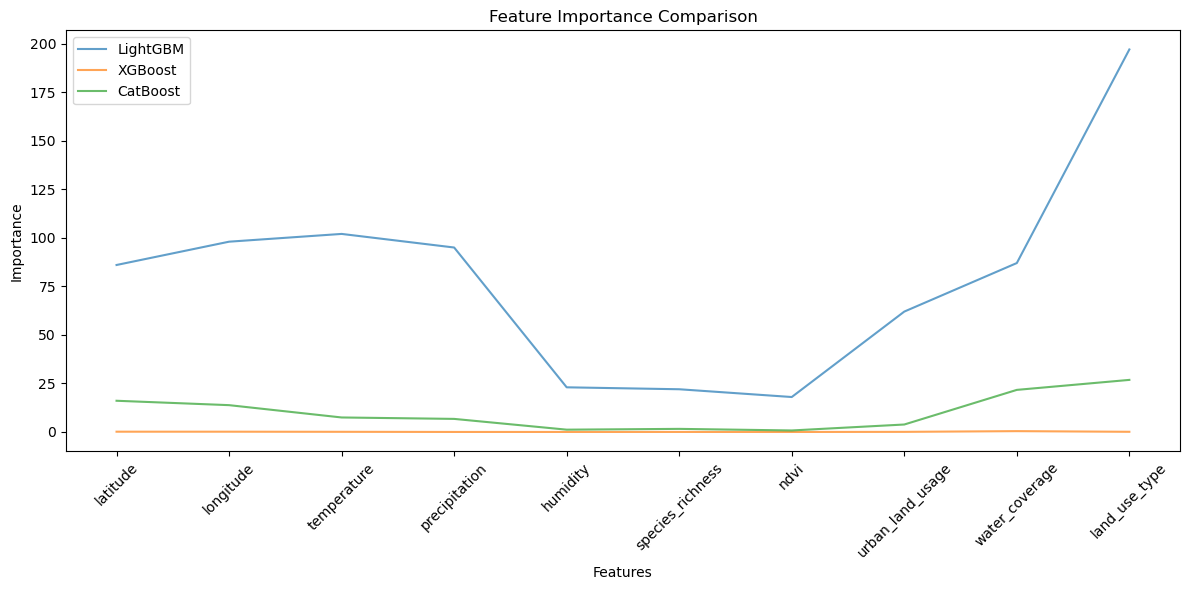

In [209]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

# Assuming df_f is your DataFrame
# Separate categorical and numerical columns
categorical_columns = ['land_use_type']
numerical_columns = ['latitude', 'longitude', 'temperature', 'precipitation', 
                    'ndvi', 'urban_land_usage', 'water_coverage','humidity', 'species_richness']

# Function for data preprocessing
def preprocess_data(df):
    df_processed = df.copy()
    
    # Handle categorical variables
    label_encoders = {}
    for col in categorical_columns:
        label_encoders[col] = LabelEncoder()
        df_processed[col] = label_encoders[col].fit_transform(df_processed[col])
    
    # Scale numerical features
    scaler = StandardScaler()
    df_processed[numerical_columns] = scaler.fit_transform(df_processed[numerical_columns])
    
    return df_processed, label_encoders, scaler

# Preprocess the data
df_processed, label_encoders, scaler = preprocess_data(df_f)

# Split features and target
X = df_processed.drop(columns=["risk_score"])
y = df_processed["risk_score"]

# Split data with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Model parameters
lgb_params = {
    'n_estimators': 100,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'subsample': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'n_jobs': -1
}

xgb_params = {
    'n_estimators': 100,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'n_jobs': -1
}

cat_params = {
    'iterations': 100,
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 3,
    'random_state': 42,
    'verbose': False
}

# Initialize and train models
# Train models
def train_model(model, X_train, y_train, X_val, y_val, model_name):
    print(f"\nTraining {model_name}...")
    if model_name == "LightGBM":
        model.fit(
            X_train, y_train,
            eval_set=(X_val, y_val),
        )
    elif model_name == "CatBoost":
        model.fit(
            X_train, y_train,
            eval_set=(X_val, y_val),
            early_stopping_rounds=50,
            verbose=100
        )
    else:  # For XGBoost
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],

        )
    return model

# Train models
models = {
    "LightGBM": LGBMRegressor(**lgb_params),
    "XGBoost": XGBRegressor(**xgb_params),
    "CatBoost": CatBoostRegressor(**cat_params)
}

predictions = {}
for name, model in models.items():
    trained_model = train_model(model, X_train, y_train, X_val, y_val, name)
    predictions[name] = trained_model.predict(X_val)

# Weighted ensemble predictions
weights = {
    "LightGBM": 0.4,
    "XGBoost": 0.3,
    "CatBoost": 0.3
}

ensemble_preds = sum(predictions[model] * weight for model, weight in weights.items())

# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{model_name} Metrics:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2 Score: {r2:.4f}")
    return rmse, r2

# Print evaluation metrics for each model
print("\nModel Evaluation Results:")
print("="*50)
for name in predictions.keys():
    evaluate_model(y_val, predictions[name], name)

# Evaluate ensemble
print("\nEnsemble Model Evaluation:")
print("="*50)
ensemble_rmse, ensemble_r2 = evaluate_model(y_val, ensemble_preds, "Weighted Ensemble")

# Feature importance analysis
def plot_feature_importance(models, feature_names):
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 6))
    for name, model in models.items():
        if hasattr(model, 'feature_importances_'):
            plt.plot(feature_names, model.feature_importances_, label=name, alpha=0.7)
    
    plt.title('Feature Importance Comparison')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot feature importance
feature_names = X_train.columns
plot_feature_importance(models, feature_names)

In [151]:
# encoder = label_encoders
# label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

In [211]:
import pickle

# Save the models
with open('models2.pkl', 'wb') as f:
    pickle.dump(models, f)

# Save the ensemble predictions weights
with open('ensemble_weights2.pkl', 'wb') as f:
    pickle.dump(weights, f)

# Save the label encoders and scaler
with open('preprocessors2.pkl', 'wb') as f:
    pickle.dump((label_encoders, scaler), f)

In [213]:
df_f

,latitude,longitude,temperature,precipitation,humidity,species_richness,ndvi,urban_land_usage,water_coverage,land_use_type,risk_score
0,51.1657,10.4515,-0.57,3.60,81,143,0.013129,0.355617,0.331348,Agricultural,0.3
1,27.1751,78.0421,10.71,0.00,54,84,0.094023,0.332316,1.000000,Commercial,0.7
2,10.8231,106.6297,24.01,0.00,94,168,0.144667,0.396237,1.000000,Residential,0.6
3,19.0760,72.8777,25.03,0.00,44,214,0.172181,0.412552,0.490919,Agricultural,0.4
4,35.6895,139.6917,2.59,3.06,55,159,0.060093,0.711808,1.000000,Residential,0.5
...,...,...,...,...,...,...,...,...,...,...,...
379,35.6895,51.3890,5.50,0.90,52,147,0.300000,0.369146,0.000329,Eco-friendly,0.1
380,51.5074,-0.1278,2.97,53.52,88,168,0.300000,0.874849,0.289484,Residential,0.5
381,48.8566,2.3522,-0.36,35.82,91,132,0.300000,0.771148,0.132744,Commercial,0.6
382,40.7128,-74.0060,6.40,87.48,90,138,0.300000,0.814820,0.005431,Agricultural,0.3


In [161]:
e = label_encoders

In [165]:
encoder = LabelEncoder()

# Fit the encoder on the data
encoder.fit(data)

# Display the classes (original values)
print("Original categories:", encoder.classes_)

TypeError: Encoders require their input argument must be uniformly strings or numbers. Got ['dict']